# IBM HR Employee Attrition

### Stacking a decsion tree on Xgboost

In [2]:
#Loading all Packages
print("==================== BLOCK 1 Started! ======================")
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.options.display.max_rows=10
pd.options.display.max_columns=50
import numpy as np
import time
import sklearn
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn import datasets
from sklearn.model_selection import cross_val_score
%matplotlib inline
r_state=52
import warnings
warnings.filterwarnings('ignore')
from six import StringIO
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn import datasets
from sklearn.model_selection import cross_val_score
import os     
os.environ["PATH"] += os.pathsep + 'C:\Program Files (x86)\Graphviz2.38\bin'
%matplotlib inline
r_state=52
import warnings
warnings.filterwarnings('ignore')
print("==================== Packages Loaded ======================")

==================== BLOCK 1 Started! ======================
==================== Packages Loaded ======================


In [3]:
print("==================== Data Loading ======================")
start_time = time.time()
df=pd.read_csv('MainEncodedData.csv')
del df['Unnamed: 0']
print("==================== Data Loaded In ======================")
print("Duration: --- %s Minutes ---" % ((time.time() - start_time)/60))
print(df.shape)

==================== Data Loading ======================
==================== Data Loaded In ======================
Duration: --- 0.00018337170282999675 Minutes ---
(1470, 51)


In [5]:
train, test = sklearn.model_selection.train_test_split(df, train_size = 0.75,random_state=r_state)
print("For Main Data Set :",df['Attrition'].count())
print("For Train Set :",train['Attrition'].count())
print("For Test Set :",test['Attrition'].count())

x_train=train.drop(train.columns[1], axis = 1)
x_test=test.drop(test.columns[1], axis = 1)
y_train=train['Attrition']
y_test=test['Attrition']

For Main Data Set : 1470
For Train Set : 1102
For Test Set : 368


The top accuracy forecast with cross validation is 84.2%
Obtained with min_impurity_decrease = 0.0
The accuracy on full training set is 100.0%
True         0   1
Predicted         
0          267  28
1           45  28
              precision    recall  f1-score   support

           0       0.91      0.86      0.88       312
           1       0.38      0.50      0.43        56

    accuracy                           0.80       368
   macro avg       0.64      0.68      0.66       368
weighted avg       0.83      0.80      0.81       368

0.8016304347826086
Duration: --- 0.48991716702779137 Minutes ---
ROC AUC: 0.68


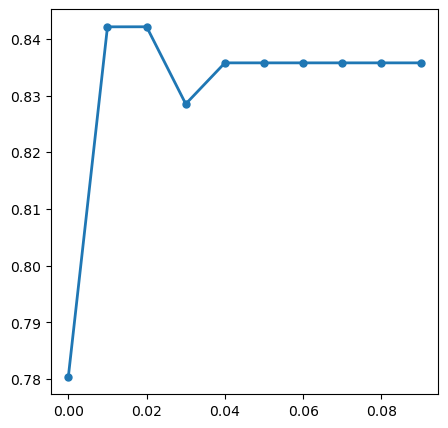

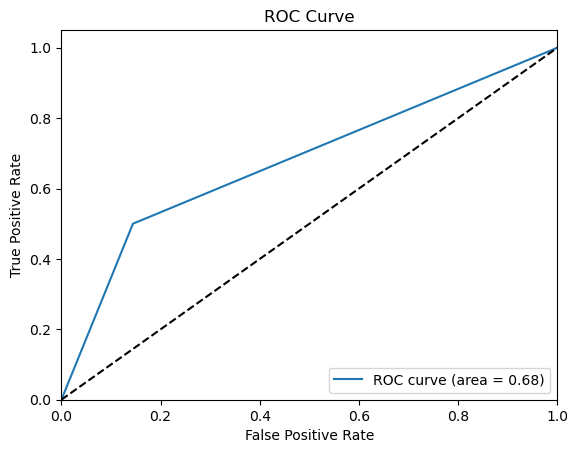

Kappa score is :0.31636807817589574


In [6]:
r_state=52
avg_scores = []
parameter_values = np.arange(0,0.1, 0.01)
for mid in parameter_values:
    estimator = tree.DecisionTreeClassifier(criterion="entropy", random_state = r_state, min_impurity_decrease = mid)
    scores = cross_val_score(estimator, x_train, y_train, scoring='accuracy', cv = 10)
    avg_scores.append(np.mean(scores))
#print(avg_scores)

plt.figure(figsize=(5,5))
plt.plot(parameter_values, avg_scores, '-o', linewidth=2, markersize=5)
print("The top accuracy forecast with cross validation is {0:.1f}%".format(avg_scores[np.argmax(avg_scores)]*100))
print("Obtained with min_impurity_decrease = {0:.1f}".format(parameter_values[np.argmax(avg_scores)]))

estimator = tree.DecisionTreeClassifier(criterion="entropy", random_state = r_state,
                                        min_impurity_decrease = 0.0)
estimator.fit(x_train,y_train)
y_predicted = estimator.predict(x_train)
accuracy_full = np.mean( y_train== y_predicted) * 100
print("The accuracy on full training set is {0:.1f}%".format(accuracy_full))


model=estimator
pred=model.predict(x_test)
cm_df = pd.DataFrame(confusion_matrix(y_test, pred).T, index=model.classes_,
                     columns=model.classes_)
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
print(cm_df)
print(classification_report(y_test, pred))
print(model.score(x_test,y_test))

print("Duration: --- %s Minutes ---" % ((time.time() - start_time)/60))

fpr, tpr, _ = roc_curve(y_test, pred)
 
# Calculate the AUC
roc_auc = auc(fpr, tpr)
print('ROC AUC: %0.2f' % roc_auc)
 
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

from sklearn.metrics import cohen_kappa_score
print("Kappa score is :"+str(cohen_kappa_score(y_test,pred)))

#### Lets feed Dtree output to another XGBOOST model 

##### Commencing forward stacking process

In [7]:
pred_train=model.predict(x_train)
pred_test=model.predict(x_test)

x_train['FeedFrom1']=pred_train
x_test['FeedFrom1']=pred_test

xgd_train=xgb.DMatrix(data=x_train,label=y_train)
xgd_test=xgb.DMatrix(data=x_test,label=y_test)

In [8]:
params = {"objective":"binary:logistic", "max_depth":4,"nthread":5,"learning_rate":0.1,
         "subsample":0.2,"colsample_bytree":0.3,"n_estimators":20,"seed":52}

# Instantiate the XGBClassifier: xg_cl
xg_cl = xgb.XGBClassifier(params=params)

# Fit the classifier to the training set
xg_cl.fit(x_train, y_train)

# Predict the labels of the train set
preds_train = xg_cl.predict(x_train)

# Compute the accuracy: accuracy
accuracy = float(np.sum(preds_train==y_train))/y_train.shape[0]
print("Training accuracy: %f" % (accuracy))

# Predict the labels of the test set
preds_test = xg_cl.predict(x_test)

# Compute the accuracy: accuracy
accuracy = float(np.sum(preds_test==y_test))/y_test.shape[0]
print("Testing accuracy: %f" % (accuracy))

Training accuracy: 1.000000
Testing accuracy: 0.801630


True         0   1
Predicted         
0          267  28
1           45  28
              precision    recall  f1-score   support

           0       0.91      0.86      0.88       312
           1       0.38      0.50      0.43        56

    accuracy                           0.80       368
   macro avg       0.64      0.68      0.66       368
weighted avg       0.83      0.80      0.81       368

0.8016304347826086
Duration: --- 0.8652830561002095 Minutes ---
ROC AUC: 0.68


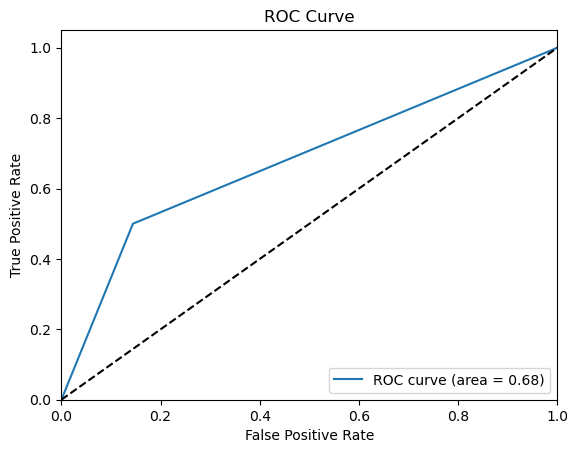

Kappa score is :0.31636807817589574


In [9]:
model=xg_cl
pred=model.predict(x_test)
cm_df = pd.DataFrame(confusion_matrix(y_test, pred).T, index=model.classes_,
                     columns=model.classes_)
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
print(cm_df)
print(classification_report(y_test, pred))
print(model.score(x_test,y_test))

print("Duration: --- %s Minutes ---" % ((time.time() - start_time)/60))

fpr, tpr, _ = roc_curve(y_test, pred)
 
# Calculate the AUC
roc_auc = auc(fpr, tpr)
print('ROC AUC: %0.2f' % roc_auc)
 
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

from sklearn.metrics import cohen_kappa_score
print("Kappa score is :"+str(cohen_kappa_score(y_test,pred)))

#### Stacking does not seem to improve accuracy instead it is hampering with our predictions